In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.functions import col, size
import pyspark.sql.functions as fn

In [2]:
# Start spark in local mode using 100gb of memory
# local mode only runs on a single node, but it will utilize all cores (We have 48!)
conf = SparkConf().setAppName("test") \
    .set('spark.driver.memory','54g') \
    .set('spark.jars.packages', 'graphframes:graphframes:0.6.0-spark2.3-s_2.11') \
    .setMaster("local[44]")
#.setMaster("yarn") # this is used when we run on hadoop, ignore for now

sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

print("Spark Version: ", sc.version)
print("defaultParallelism: ", sc.defaultParallelism)
print("Spark WebURLL ", sc.uiWebUrl) # you can view running jobs here, but I am only able to connect to it via VNC rn, maybe SSH tunneling will fix this? idk

Spark Version:  2.4.4
defaultParallelism:  44
Spark WebURLL  http://c251-102.wrangler.tacc.utexas.edu:4040


In [3]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *

In [4]:
import json
from pyspark.sql.types import StructType

In [5]:
nodes_path = '/data/06271/cju256/nodes.json'

edges_path = '/data/06271/cju256/money_flow_weighted_edgelist.csv'
nodes = sqlContext.read.json(nodes_path)
edges = sqlContext.read.csv(edges_path)

In [6]:
nodes.printSchema()

root
 |-- about: string (nullable = true)
 |-- cancelled: boolean (nullable = true)
 |-- date_created: string (nullable = true)
 |-- email: string (nullable = true)
 |-- external_id: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- id: long (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- lastname: string (nullable = true)
 |-- name: string (nullable = true)
 |-- num_friends: long (nullable = true)
 |-- phone: string (nullable = true)
 |-- picture: string (nullable = true)
 |-- username: string (nullable = true)



In [9]:
edges = edges.withColumnRenamed('_c0', 'src').withColumnRenamed('_c1', 'dst').withColumnRenamed('_c2', 'weight')
edges.printSchema()

root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- weight: string (nullable = true)



In [10]:
G2 = GraphFrame(nodes, edges)

In [11]:
motifs = G2.find("(a)-[e]->(b); (b)-[e2]->(a)")

In [12]:
motifs.show()

+--------------------+------------------+--------------------+------------------+
|                   a|                 e|                   b|                e2|
+--------------------+------------------+--------------------+------------------+
|[, false, 2011-08...|    [55976, 11, 1]|[, false, 2009-07...|    [11, 55976, 1]|
|[, false, 2014-04...|  [1315774, 13, 1]|[, false, 2009-07...|  [13, 1315774, 1]|
|[, false, 2014-10...|  [2489219, 46, 1]|[, false, 2009-08...|  [46, 2489219, 3]|
|[, false, 2013-11...|  [746556, 112, 4]|[, false, 2009-09...|  [112, 746556, 4]|
|[, false, 2015-08...| [6060547, 158, 3]|[, false, 2009-09...| [158, 6060547, 5]|
|[, false, 2012-02...|   [87794, 173, 8]|[, false, 2009-09...|  [173, 87794, 12]|
|[, false, 2014-01...|  [928039, 224, 1]|[, false, 2009-10...|  [224, 928039, 1]|
|[, false, 2015-01...| [3342324, 830, 1]|[, false, 2009-11...| [830, 3342324, 1]|
|[, false, 2010-04...|   [6675, 1009, 3]|[, false, 2009-11...|   [1009, 6675, 4]|
|[, false, 2014-

In [24]:
motifs.filter("e2.src == 55976 and e2.dst == 11").show()

+--------------------+--------------+--------------------+--------------+
|                   a|             e|                   b|            e2|
+--------------------+--------------+--------------------+--------------+
|[, false, 2009-07...|[11, 55976, 1]|[, false, 2011-08...|[55976, 11, 1]|
+--------------------+--------------+--------------------+--------------+



In [13]:
motifs.count()

48566155

### The motifs finder will count every pair of edges twice, as seen above. Therefore we divide by 2, to get the proper number of reciprocated edges.

In [26]:
48566155/2

24283077.5

In [14]:
edges.count()

131705390

In [28]:
24283077/131705390

0.18437420822336884

# Interpretations of this

Cold Hard e cash had a reciprocity of 0.147.


Based on the traditional interpretation of reciprocity: 
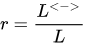


We'd say the reciprocity is

$r = \frac{24283077} {131705390} = 0.18437420822336884$